# Principal components analysis for order parameter construction

In [1]:
from analysis_tools.read_gsd import ReadGSD
from analysis_tools.feature_creation import FrameToFeatures, TrajectoryToFeatures
from analysis_tools.feature_creation import FrameToFeaturesComposition, TrajectoryToFeaturesComposition

---

## Models

In [2]:
from numpy import array, arange

### Model data

#### Hard disks

In [3]:
particle_inc = 100 #skip this many particles in generating features; #wp: because it selects index 0 be default, rounds up to integer if not a mulptiple of Ntot
N_nn = 400 #number of nearest nighbors for pca analysis #wp:Should not be bigger than Ntotal
nn_inc = 20 #reduces the number of nearest neighbors to include as features
split = 1 #chunks the data up so it can be processed by the pca tool if really large

method = ['distance']

In [4]:
#specify what data to read in and process
#wp:there are 55 eta points given range below
#file_data = [(arange(0.550, 0.690001, 0.005), 'ellipsoids'), (arange(0.695, 0.800001, 0.005),'ellipsoids')]  
file_data = [(arange(0.550, 0.800001, 0.01),'ellipsoids/kappa_3.0')]  

### Density range

In [5]:
#wp: the `_' variable is a dummy return variable like `~' in matlab
#wp: Here, the for loop returns two arguments but only keeps the first that contains all the numbers
etas = []
[etas.extend(etas_) for etas_, _ in file_data]
etas = array(etas)

---

## Perfom PCA

In [6]:
from numpy import array_split
from sklearn.decomposition import IncrementalPCA

### Train on ideal gas structure first to identify trivial variance contributions

In [7]:
n_components_ig = N_nn/nn_inc  #for this the more the better, however, 50 is probably enough

In [302]:
###Note that this ideal gas variance comes from the fact that particles get sorted and creates an artificial correlation
randomize = True
#wp: incremental pca structure for ideal gas
incpca_ig = IncrementalPCA(n_components=n_components_ig, whiten=False)

frames = None
features = None
split_features = None

#wp: return two variables from file data in for loop: the etas list and the file directory
for etas_, file_base in file_data:
    #wp: for each eta in the list
    #for eta in etas_:
    for eta in etas_[-1:]:
        print 'eta={}'.format(eta)
        #wp:access GSD files from directory given in 'file_base' variable
        filename = "{}/trajectory_{:.4f}.gsd".format(file_base, eta)
        #wp:Returns frames as dictionary [coords,diameters,types,L,D]. Size is (trajectory prod steps)/(trajectory collect period)
        frames = ReadGSD(filename, shuffle_data=True, randomize=randomize)
        
        #wp: If array_split(array,1) then array is not split, although it does get transformed into a single list it seems
        frames_split = array_split(frames, split)
       
        #wp: resets frame
        frames = None
        count = 0
        
        for frames_partial in frames_split:
            #wp:All trajectories done at eta_ get passed down at once
            features_partial = TrajectoryToFeatures(frames_partial, 
                                                    N_nn=N_nn, 
                                                    method=method, 
                                                    particle_inc=particle_inc, 
                                                    nn_inc=nn_inc)
            
            incpca_ig.partial_fit(features_partial)
            count = count + 1
            print "Frame partials: ", count

        frames_split = None
        features_partial_ig=features_partial

eta=0.69
Frame partials:  1
eta=0.8
Frame partials:  1


### Train on actual data with trivial data variance removed by the ideal gas model

In [287]:
n_components = N_nn/nn_inc #this number will not affect the quality of the result just the computation time and amount of info returned

In [288]:
randomize = False
incpca = IncrementalPCA(n_components=n_components , whiten=False)

frames = None
features = None
split_features = None

for etas_, file_base in file_data:
    for eta in etas_:
        print 'eta={}'.format(eta)
        filename = "{}/trajectory_{:.4f}.gsd".format(file_base, eta)
        frames = ReadGSD(filename, shuffle_data=True, randomize=randomize)
        
        frames_split = array_split(frames, split)
        frames = None
        count = 0
        for frames_partial in frames_split:
            features_partial = TrajectoryToFeatures(frames_partial, 
                                                    N_nn=N_nn, 
                                                    method=method, 
                                                    particle_inc=particle_inc, 
                                                    nn_inc=nn_inc)
            #wp:project the *hard disk* feature vector unto a lower dimensionalized representation of the ideal gas space that captures most of the ideal gas variance
            #wp:This then creates a 'hard disk' feature vector that strongly contains the sorting variance seen in the ideal gas
            features_partial_ig_projection = incpca_ig.inverse_transform(incpca_ig.transform(features_partial))
            #wp:remove this partial reconstructed hard disk ideal gas projection from real data features
            incpca.partial_fit(features_partial - features_partial_ig_projection)
            count = count + 1
            print "Frame split: ", count
        #wp:resets frame split
        frames_split = None

eta=0.55
Frame split:  1
eta=0.555
Frame split:  1
eta=0.56
Frame split:  1
eta=0.565
Frame split:  1
eta=0.57
Frame split:  1
eta=0.575
Frame split:  1
eta=0.58
Frame split:  1
eta=0.585
Frame split:  1
eta=0.59
Frame split:  1
eta=0.595
Frame split:  1
eta=0.6
Frame split:  1
eta=0.605
Frame split:  1
eta=0.61
Frame split:  1
eta=0.615
Frame split:  1
eta=0.62
Frame split:  1
eta=0.625
Frame split:  1
eta=0.63
Frame split:  1
eta=0.635
Frame split:  1
eta=0.64
Frame split:  1
eta=0.645
Frame split:  1
eta=0.65
Frame split:  1
eta=0.655
Frame split:  1
eta=0.66
Frame split:  1
eta=0.665
Frame split:  1
eta=0.67
Frame split:  1
eta=0.675
Frame split:  1
eta=0.68
Frame split:  1
eta=0.685
Frame split:  1
eta=0.69
Frame split:  1
eta=0.695
Frame split:  1
eta=0.7
Frame split:  1
eta=0.705
Frame split:  1
eta=0.71
Frame split:  1
eta=0.715
Frame split:  1
eta=0.72
Frame split:  1
eta=0.725
Frame split:  1
eta=0.73
Frame split:  1
eta=0.735
Frame split:  1
eta=0.74
Frame split:  1
eta=0.74

In [247]:
########wp: System fit *without ideal gas*
randomize = False
incpca = IncrementalPCA(n_components=n_components , whiten=False)

frames = None
features = None
split_features = None

split=1
for etas_, file_base in file_data:
    for eta in etas_:
        print 'eta={}'.format(eta)
        filename = "{}/trajectory_{:.4f}.gsd".format(file_base, eta)
        frames = ReadGSD(filename, shuffle_data=True, randomize=randomize)
        
        frames_split = array_split(frames, split)
        frames = None
        count = 0
        for frames_partial in frames_split:
            features_partial = TrajectoryToFeatures(frames_partial, 
                                                    N_nn=N_nn, 
                                                    method=method, 
                                                    particle_inc=particle_inc, 
                                                    nn_inc=nn_inc)

            #wp: fits pure system features (no idea gas reduction)
            incpca.partial_fit(features_partial )
            count = count + 1
            print "Frame split: ", count
        #wp:resets frame split
        frames_split = None

eta=0.55
Frame split:  1
eta=0.555
Frame split:  1
eta=0.56
Frame split:  1
eta=0.565
Frame split:  1
eta=0.57
Frame split:  1
eta=0.575
Frame split:  1
eta=0.58
Frame split:  1
eta=0.585
Frame split:  1
eta=0.59
Frame split:  1
eta=0.595
Frame split:  1
eta=0.6
Frame split:  1
eta=0.605
Frame split:  1
eta=0.61
Frame split:  1
eta=0.615
Frame split:  1
eta=0.62
Frame split:  1
eta=0.625
Frame split:  1
eta=0.63
Frame split:  1
eta=0.635
Frame split:  1
eta=0.64
Frame split:  1
eta=0.645
Frame split:  1
eta=0.65
Frame split:  1
eta=0.655
Frame split:  1
eta=0.66
Frame split:  1
eta=0.665
Frame split:  1
eta=0.67
Frame split:  1
eta=0.675
Frame split:  1
eta=0.68
Frame split:  1
eta=0.685
Frame split:  1
eta=0.69
Frame split:  1
eta=0.695
Frame split:  1
eta=0.7
Frame split:  1
eta=0.705
Frame split:  1
eta=0.71
Frame split:  1
eta=0.715
Frame split:  1
eta=0.72
Frame split:  1
eta=0.725
Frame split:  1
eta=0.73
Frame split:  1
eta=0.735
Frame split:  1
eta=0.74
Frame split:  1
eta=0.74

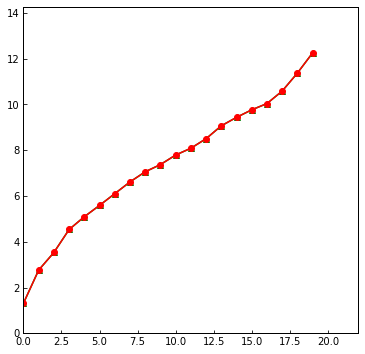

In [308]:
###Plots the feature matrix for the last eta
fpartial_ig=np.asarray(features_partial_ig);
fpartial=np.asarray(features_partial);
sample_num=3000
#wp:ideal gas
plt.plot(fpartial_ig[sample_num,:],'g-^')
#wp:system
plt.plot(fpartial[sample_num,:],'r-o')
plt.xlim(0,n_components+2);plt.ylim(0,fpartial[sample_num,-1]+2);

### Compute the order parameters based on two nested models

In [289]:
#wp: Once *all* the data has been fit with pca, then start getting the transformed components using *all* the fitted data
randomize=False
frames = None
features = None
raw_OPs = []

split=1;
for etas_, file_base in file_data:
    for eta in etas_:
        print 'eta={}'.format(eta)
        filename = "{}/trajectory_{:.4f}.gsd".format(file_base, eta)
        frames = ReadGSD(filename, shuffle_data=True, randomize=randomize)
        
        frames_split = array_split(frames, split)
        frames = None
        count = 0
        means = []
        #wp: Array of transformed/projected pca features. OP=order parameter
        raw_OPs_single = []
        for frames_partial in frames_split:
            #wp: returns nearest sorted neighbor distances for traj_frames*Npart/particle_inc examples
            features_partial = TrajectoryToFeatures(frames_partial, 
                                                    N_nn=N_nn, 
                                                    method=method, 
                                                    particle_inc=particle_inc, 
                                                    nn_inc=nn_inc)
            #wp:regenerate the *hard disk* projection on the ideal gas space to subtract from the hard disk feature vector
            features_partial_ig_projection = incpca_ig.inverse_transform(incpca_ig.transform(features_partial))
            transformed_features_partial = incpca.transform(features_partial - features_partial_ig_projection)
            #transformed_features_partial = incpca.transform(features_partial)
            raw_OPs_single.append(transformed_features_partial)
            count = count + 1
            print count
        #wp: Order parameters for each eta: list of arrays of size (# of etas)x(traj_frames*Npart/particle_inc x N_nn/nn_inc (or n_components))
        #wp: So for a run of Npart=400,particle_inc=10, with 100 traj frames and choosing N_nn=30, keeping every nn_inc=2 we get (# etas)x(4000x15)
        raw_OPs.append(raw_OPs_single)  

eta=0.55
1
eta=0.555
1
eta=0.56
1
eta=0.565
1
eta=0.57
1
eta=0.575
1
eta=0.58
1
eta=0.585
1
eta=0.59
1
eta=0.595
1
eta=0.6
1
eta=0.605
1
eta=0.61
1
eta=0.615
1
eta=0.62
1
eta=0.625
1
eta=0.63
1
eta=0.635
1
eta=0.64
1
eta=0.645
1
eta=0.65
1
eta=0.655
1
eta=0.66
1
eta=0.665
1
eta=0.67
1
eta=0.675
1
eta=0.68
1
eta=0.685
1
eta=0.69
1
eta=0.695
1
eta=0.7
1
eta=0.705
1
eta=0.71
1
eta=0.715
1
eta=0.72
1
eta=0.725
1
eta=0.73
1
eta=0.735
1
eta=0.74
1
eta=0.745
1
eta=0.75
1
eta=0.755
1
eta=0.76
1
eta=0.765
1
eta=0.77
1
eta=0.775
1
eta=0.78
1
eta=0.785
1
eta=0.79
1
eta=0.795
1
eta=0.8
1


### Compute order parameter stats

In [269]:
from numpy import array, mean, std, abs

In [293]:
OPs = []
OPs_std = []
OPs_abs = []

for single_eta in raw_OPs:
    merged_data = []
    
    for split in single_eta:
        merged_data.extend(split)
    OPs.append(mean((split), axis=0))
    OPs_std.append(std(split, axis=0))
    OPs_abs.append(mean(abs(split), axis=0))

OPs = array(OPs)
OPs_std = array(OPs_std)
OPs_abs = array(OPs_abs)



#wp:figuring things out...
print "The feature matrix input for each eta is of dimensions",len(features_partial),len(features_partial[0])
print len(raw_OPs_single[0]),len(raw_OPs_single[0][0])


eta_index=0
print "Number of rows: ", len(raw_OPs)
print "Number of columns: ", len(raw_OPs[eta_index])
print "Array size for each eta: ", raw_OPs[eta_index][0].shape
print raw_OPs[eta_index][0][1]

#wp: for the averaged value
print "Shape of average order parameter", OPs.shape

The feature matrix input for each eta is of dimensions 8000 20
8000 20
Number of rows:  51
Number of columns:  1
Array size for each eta:  (8000, 20)
[ 2.85546684e-17 -4.91631399e-18 -4.77054209e-19  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
Shape of average order parameter (51, 20)


---

## Check out the results of PCA

In [120]:
import matplotlib.pyplot as plt
import numpy as np

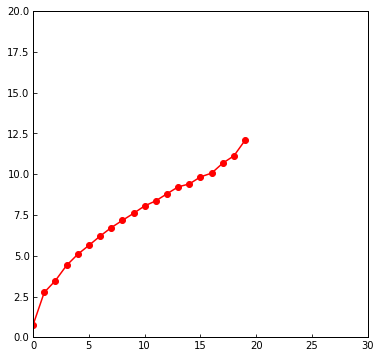

In [299]:
###Plots the feature matrix for the last eta
fpartial=np.asarray(features_partial);
plt.plot(fpartial[1250,:],'r-o')
plt.xlim(0,n_components+10);plt.ylim(0,20);

### Explained variance

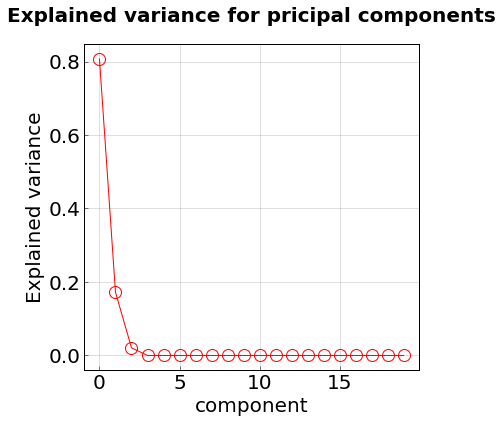

In [294]:
#plot the principal components
colors = 200*['green', 'purple', 'orange', 'teal', 'black', 'red']

plt.plot(incpca.explained_variance_ratio_, marker='o', linewidth=1.0, markersize=12, color = 'red', markerfacecolor='None')    

#backround grid details
axes = plt.gca()
axes.grid(b = True, which = 'both', axis = 'both', color = 'gray', linestyle = '-', alpha = 0.5, linewidth = 0.5) 
#axes.set_axis_bgcolor('white')  

#font scpecifications
title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}                                                   

#figure size and tick style
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=4, width=0.5)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

#plt.yscale('log')
#!!!wp: Why eta? #Shouldn't be features?
plt.xlabel(r'component', y=3, fontsize=20, fontdict = axis_label_font)
plt.ylabel(r'Explained variance', fontsize=20, fontdict = axis_label_font)

#title and axis labels
plt.tick_params(axis='both', labelsize=20)
plt.title('Explained variance for pricipal components', y=1.05, fontdict = title_font)

plt.show()

### Principal component weights

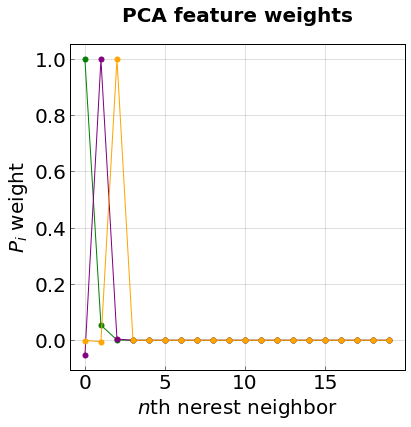

In [295]:
#plot the principal components
colors = 200*['green', 'purple', 'orange', 'teal', 'black', 'red']
for i in range(0,3):
    p_data = incpca.components_[i]
    plt.plot(range(len(incpca.components_[0])), p_data, marker='o', linewidth = 1.0, markersize=5, color = colors[i])  

#backround grid details
axes = plt.gca()
axes.grid(b = True, which = 'both', axis = 'both', color = 'gray', linestyle = '-', alpha = 0.5, linewidth = 0.5) 
#axes.set_axis_bgcolor('white')  

#font scpecifications
title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}                                                   

#figure size and tick style
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=4, width=0.5)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

#axis range and labels (also specify if log or not)
#plt.xlim(0.1,80)
#plt.ylim(-1,0)
#plt.ylim(0,0.5)
#plt.ylim(-2,1.5)
#plt.ylim(5, 13)
#plt.ylim(1, 0.001)
#plt.ylim(-2000.0, 2000)

#plt.xscale('log')
#wp:axes labels
plt.xlabel(r'$n$th nerest neighbor', y=3, fontsize=20, fontdict = axis_label_font)
plt.ylabel(r'$P_{i}$ weight', fontsize=20, fontdict = axis_label_font)

#title and axis labels
plt.tick_params(axis='both', labelsize=20)
plt.title('PCA feature weights', y=1.05, fontdict = title_font)

plt.show()

### Order parameters

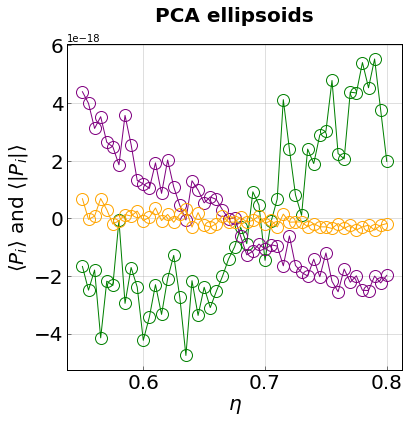

In [298]:
#plot the principal components
colors = 200*['green', 'purple', 'orange', 'teal', 'black', 'red']
for i in range(0,3): #12,13
    p_data = OPs[:,i]
    plt.plot(etas, (p_data), marker='o', linewidth = 1.0, markersize=12, color = colors[i], markerfacecolor='None')
    p_data = OPs_std[:,i]
    #plt.plot(etas, (p_data), marker='^', linewidth = 1.0, markersize=12, color = colors[i])

#backround grid details
axes = plt.gca()
axes.grid(b = True, which = 'both', axis = 'both', color = 'gray', linestyle = '-', alpha = 0.5, linewidth = 0.5) 


#figure size and tick style
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=4, width=0.5)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

#axis range and labels (also specify if log or not)
#plt.xlim(0.60, 0.84)
#plt.ylim(-0.1,0.1)

#plt.ylim(-0.1,0.1)
#plt.yscale('log')

#plt.yscale('log')
plt.xlabel(r'$\eta$', y=3, fontsize=20, fontdict = axis_label_font)
plt.ylabel(r'$\langle P_{i} \rangle$ and $\langle |P_{i}| \rangle$', fontsize=20, fontdict = axis_label_font)

#title and axis labels
plt.tick_params(axis='both', labelsize=20)
plt.title('PCA ellipsoids', y=1.05, fontdict = title_font)

plt.show()

In [153]:
OPs_400_20=OPs;   #wp: N_nn=400, nn_inc=20, using 10000 samples-

In [166]:
OPs_200_10=OPs;   #wp: N_nn=200, nn_inc=10, using 10000 samples-

In [179]:
OPs_400_10=OPs;   #wp: N_nn=400, nn_inc=10, using 10000 samples-

In [232]:
OPs_400_40_10k=OPs; #wp: N_nn=400, nn_inc=40, using 10000 samples-

In [246]:
OPs_400_20_ig=OPs;  #wp: N_nn=400, nn_inc=40, using 10000 samples-

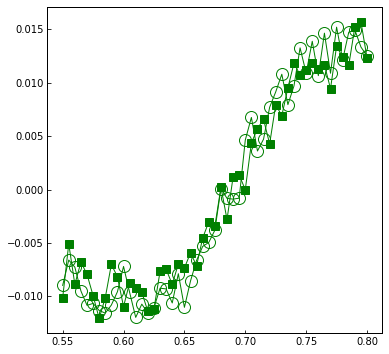

In [233]:
#plot the principal components
colors = 200*['green', 'purple', 'orange', 'teal', 'black', 'red']
for i in range(0,1): #12,13
    p_data = OPs_400_40_10k[:,i]
    plt.plot(etas, (p_data), marker='o', linewidth = 1.0, markersize=12, color = colors[i], markerfacecolor='None')
    #p_data = OPs_200_10[:,i]
    #plt.plot(etas, (p_data), marker='^', linewidth = 1.0, markersize=8, color = colors[i])
    p_data = OPs_400_10[:,i]
    plt.plot(etas, (p_data), marker='s', linewidth = 1.0, markersize=8, color = colors[i])